Video games have been a source of joy and inspiration since their creation. Classics like Nintendo, Sega, and Atari influenced a whole generation of entertainment. Not only are these programs fun, but they are also a great source of information as a whole because it allows us to get a deeper look into consumer interests. We will be able to learn what types of games are popular and profitable. This project will therefore analyze video game sales data to learn about what is popular in video game production. We are then allowed to make better decisions about game production as well as how and where to market these games.

Our first task will be to explore the data. This data set was compiled on Dec 12, 2016 and is available from https://data.world/craigkelly/steam-game-data. This data set consists of  13,357 observations with 78 variables and represents the game store available on the pc gaming platform Steam at the time of collection. In this instance we will be handpicking our variables of interest for simplicity purposes. 
We will choose our explanatory variables to be:<br>
<br>
    1) The set of variables that indicate game category<br> 
    2) The set of variables that indicate game genre<br> 
    3) Recommendation count<br> 
    4) PriceFinal<br>
    5) PriceInitial<br>
    6) SteamSpyOwners: Estimated # of owners up to March 2009<br>
    7) SteamSpyPlayersEstimate: Estimated # of players up to March 2009<br>
  
We must note that the data taken from Steam Spy is an estimate with it's own variance.

Now our problem is where to begin. Let’s first look at our original goal: to see what characteristics make the most influence upon game quality. From this we need to decide upon a related target variable. We can do this with Metacritic score or Recommendation count. The problem with recommendation count though is that there are both good as well as bad recommendations. Let’s focus on Metacritic score in the mean time.

Let us import the data as well as various libraries that will be of use at this time. We will also create some extra variables for possible future purposes.

In [1]:
import numpy as np
import pprint
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statistics
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from math import exp, expm1

data = pd.read_csv(r'C:\Users\Darwin Uy\Dropbox\Thinkful\Assignment for Module\Capstone 1\1 Original Data\craigkelly_team_game_data\craigkelly_steam_game_data\original\games_features.csv')
data['Intercept'] = 1 #Get Intercept to do the algebra; regression, because of the format used
data['RecCountInd'] = (0 < data['RecommendationCount'])  # for model selction
data['MCriticInd'] = (0 < data['Metacritic'])   # for model selction

# Data cleaning
From previous investigation, we need to start defining the population.
This is due to the importance of representative sampling; the sample has to represent the population of interest.
In this case we are dropping the cases where 'GenreIsNonGame' is True because we are looking video games. Steam is a large sales platform that offers not just games, but also various other softwares.

In [2]:
data=data[data['GenreIsNonGame']==False] 

Let us now check for repeated observations as well as missing data.
We will drop the missing data in this instance because we notice that there are 5 entries that contain missing values.
We will consider response name as the row label because this indicates the game title, and should be unique to each game. We will use the sum function to aggregate the data and see how many observations are duplicate.

In [3]:
print("The number of duplicate data points is equal to " + str(sum(data.duplicated('ResponseName'))) + ".")
print("The number of data points with null entries is equal to " + str(sum(data.isnull().sum())) + ".")

The number of duplicate data points is equal to 157.
The number of data points with null entries is equal to 5.


From the previous check we can see that there are 157 duplicate values and 5 null entries. Further inspection shows that these null values come from "query name", "support email", "support url", and "legalnotice". None of these variables will be used in our analysis so in this case we are very lucky. But let us get rid of duplicate entries as well as entries with null values for the time being.
note that repetition may mean a weight

In [4]:
data=data.drop_duplicates('ResponseName',keep='first')
data=data.dropna()

Let us take this opportunity to create some lists for later use. 
We will as well as recode them into numeric form: <br>
gamegen: game genre <br>
gamecat: game category <br>
We note that these variables are boolean variables and also that games can fall into multiple categories and genres. 

In [5]:
#Let us create these lists
gamegen=['GenreIsIndie', 'GenreIsAction',\
         'GenreIsAdventure', 'GenreIsCasual', 'GenreIsStrategy',\
         'GenreIsRPG', 'GenreIsSimulation', 'GenreIsEarlyAccess',\
         'GenreIsFreeToPlay', 'GenreIsSports', 'GenreIsRacing', 'GenreIsMassivelyMultiplayer']

gamecat=['CategorySinglePlayer', 'CategoryMultiplayer', 'CategoryCoop',\
         'CategoryMMO', 'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',\
         'CategoryIncludeLevelEditor', 'CategoryVRSupport']

contvar=['RecommendationCount','PriceFinal','PriceInitial','SteamSpyOwners',\
         'SteamSpyPlayersEstimate']

data[gamegen]=data[gamegen].astype(int)
data[gamecat]=data[gamecat].astype(int)

# Now that the Data is clean, how about we take some time to explore the top 10 games available on steam according to Metacritic.

In [6]:
TopTable=pd.concat([data.nlargest(10,'Metacritic')[['ResponseName', 'ReleaseDate','Metacritic']], \
                    data.nlargest(10,'Metacritic')[gamegen].sum(axis=1),\
                    data.nlargest(10,'Metacritic')[gamecat].sum(axis=1), \
                    data.nlargest(10,'Metacritic')[['RecommendationCount','PriceFinal','PriceInitial',\
                                                    'SteamSpyOwners', 'SteamSpyPlayersEstimate']]] , axis = 1)
TopTable.rename(columns={0 : '#Genres', 1 : '#Categories'}, inplace=True)
TopTable

,ResponseName,ReleaseDate,Metacritic,#Genres,#Categories,RecommendationCount,PriceFinal,PriceInitial,SteamSpyOwners,SteamSpyPlayersEstimate
6,Half-Life,Nov 8 1998,96,1,2,12486,9.99,9.99,5927504,2268772
10,Half-Life 2,Nov 16 2004,96,1,2,35792,9.99,9.99,9901173,5695963
232,BioShock(tm),Aug 21 2007,96,2,1,16260,19.99,19.99,3635595,2429649
3088,Grand Theft Auto V,Apr 13 2015,96,2,2,136846,59.99,59.99,5886074,5756584
24,Portal 2,Apr 18 2011,95,2,3,73128,19.99,19.99,8741499,7282849
57,QUAKE,Aug 3 2007,94,1,3,1266,4.99,4.99,340047,181860
144,Sid Meiers Civilization(r) IV,Oct 25 2006,94,1,3,887,19.99,19.99,1422601,596158
273,BioShock Infinite,Mar 25 2013,94,1,1,55512,29.99,29.99,4619328,3526192
358,Grand Theft Auto: Vice City,Jan 10 2011,94,1,1,4866,9.99,9.99,1830263,896031
579,The Elder Scrolls IV: Oblivion(r) Game of the ...,Jun 16 2009,94,1,1,7792,14.99,14.99,1728033,1332209


# These are the top games according to Metacritic. <br> We need to figure out why.....

One thing that we must notice is that age of some of these games. There are instances in which a game was releases before te Steam store was created, which hints at why these top games have final and initial prices seen. Games with metacritic score of 96 were truly revolutionary games, but we also need to account for the technology of that time. Another thing that we notice is that top games tend to fall into 1 or 2 categories and genres.

Let us now look at our target variable first: Metacritic score. We choose this as our target variable because is is an aggregated review of games as well as the most trusted reviews in the gaming industry. To start we will look at the continuous variables and their relation to Metacritic Score.

In [7]:
data[["Metacritic"] + contvar].describe().T

,count,mean,std,min,25%,50%,75%,max
Metacritic,12876.0,12.233924,2.740043e+01,0.0,0.00,0.00,0.00,96.00
RecommendationCount,12876.0,1139.913405,1.537050e+04,0.0,0.00,0.00,242.00,1427633.00
PriceFinal,12876.0,8.019578,9.128458e+00,0.0,1.99,4.99,9.99,234.99
PriceInitial,12876.0,8.358860,1.009879e+01,0.0,1.99,5.99,9.99,234.99
SteamSpyOwners,12876.0,164177.630087,1.132557e+06,0.0,897.00,9864.00,60979.00,90687580.00
SteamSpyPlayersEstimate,12876.0,107010.873408,1.018562e+06,0.0,538.00,4304.00,28696.00,90687580.00


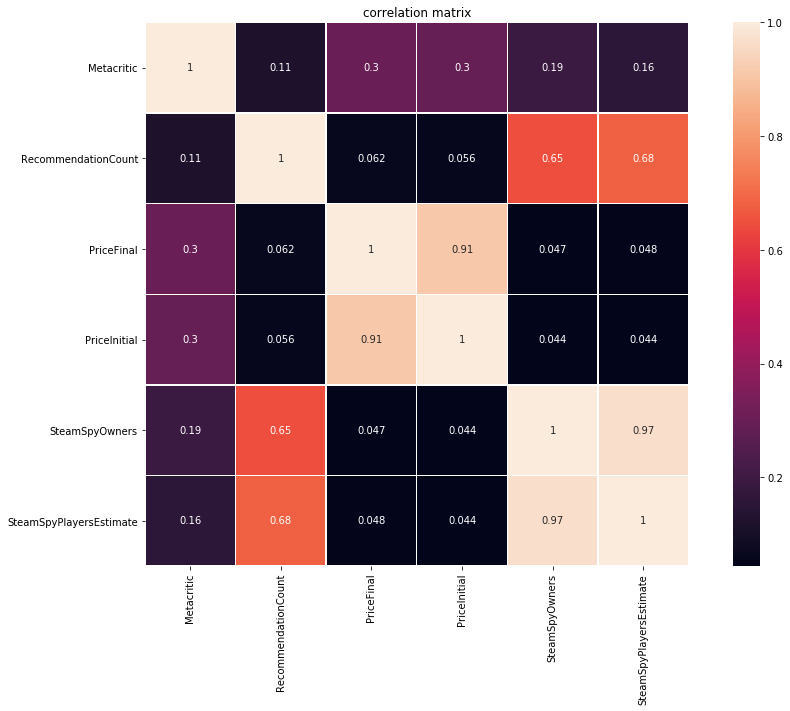

In [8]:
plt.rcParams['figure.figsize'] = (16,10)  
corrmat = data[['Metacritic'] + contvar].corr()
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title('correlation matrix')
plt.show()

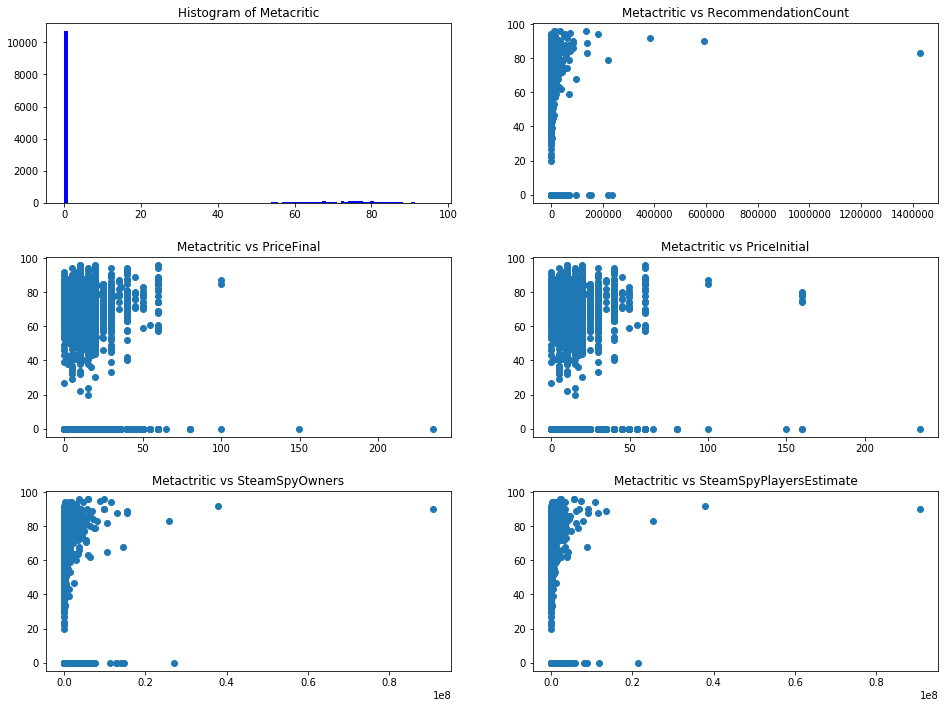

In [9]:
plt.rcParams['figure.figsize'] = (16,10)       #change the display size
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(bottom=.05, top=.95, hspace=.3)
axs[0 , 0].hist(data['Metacritic'], color='blue', bins=100)
axs[0 , 0].set_title('Histogram of Metacritic')

i = 0
j = 1
for item in list(contvar):
    axs[i , j].scatter(x=data[item], y=data['Metacritic'])
    axs[i , j].set_title('Metactritic vs ' + item)
    if j < 1 :
        j += 1    
    else:
        i += 1
        j = 0
plt.show()

We can see that there is a major cause of concern. The vast majority of Metacritic scores are mainly 0.  There are several reasons this can happen. In this analysis I will divide this data into 2 groups, Zero and Non-Zero Metacritic scores, and focus mainly on Non-Zero Metacritic scores. We will first see the difference before and after. We also see that each of these explanatory variables occasionally yield high values.

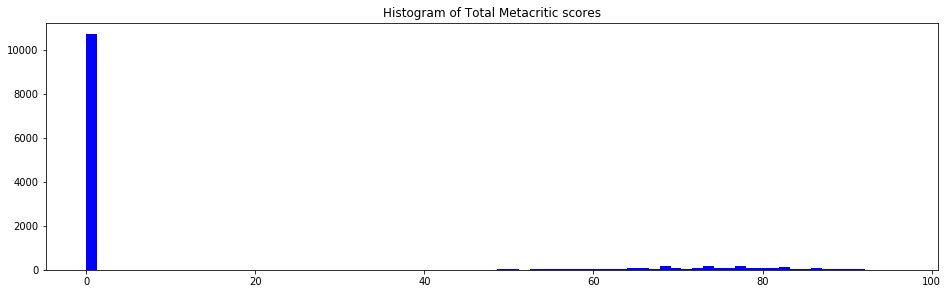

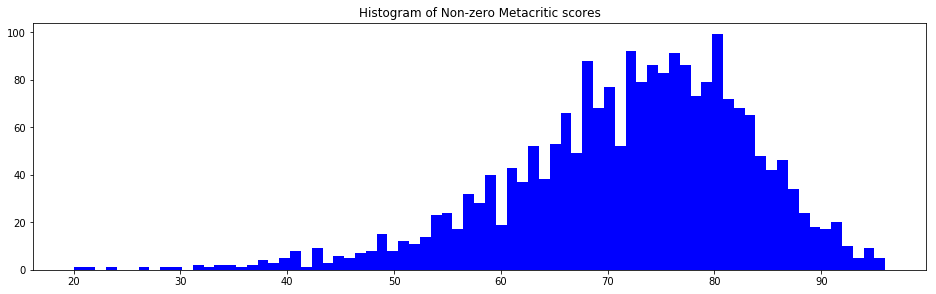

In [22]:
data1=data[data['Metacritic']>0]

NBins=75
plt.rcParams['figure.figsize'] = (16,10) 

plt.subplot(2, 1, 1)
plt.hist(data['Metacritic'], color='blue', bins=NBins)
plt.title('Histogram of Total Metacritic scores')
plt.show()

plt.subplot(2, 1, 2)
plt.hist(data1['Metacritic'], color='blue', bins=NBins)
plt.title('Histogram of Non-zero Metacritic scores') 
#plt.tight_layout()
plt.show()

# looks like order matters in this situation

In [11]:
Diff1=pd.concat([data['Metacritic'].describe(), \
                 data1['Metacritic'].describe(), \
                 data1['Metacritic'].describe()-data['Metacritic'].describe()] , axis = 1)
Diff1.columns=['Including 0 Values', 'Excluding 0 Values', 'Difference']
print(Diff1)
data1[['Metacritic'] + contvar].describe().T

       Including 0 Values  Excluding 0 Values    Difference
count        12876.000000         2192.000000 -10684.000000
mean            12.233924           71.863139     59.629215
std             27.400434           11.168780    -16.231654
min              0.000000           20.000000     20.000000
25%              0.000000           66.000000     66.000000
50%              0.000000           73.000000     73.000000
75%              0.000000           80.000000     80.000000
max             96.000000           96.000000      0.000000


,count,mean,std,min,25%,50%,75%,max
Metacritic,2192.0,71.863139,1.116878e+01,20.0,66.0000,73.00,80.00,96.00
RecommendationCount,2192.0,4494.555201,3.571764e+04,0.0,136.0000,503.50,2041.00,1427633.00
PriceFinal,2192.0,13.977609,1.038720e+01,0.0,8.1775,9.99,19.99,99.99
PriceInitial,2192.0,14.795114,1.328979e+01,0.0,9.9900,9.99,19.99,159.99
SteamSpyOwners,2192.0,581982.325274,2.465677e+06,0.0,36542.2500,131912.00,460031.50,90687580.00
SteamSpyPlayersEstimate,2192.0,412575.178832,2.332568e+06,0.0,17756.0000,67704.50,270593.50,90687580.00


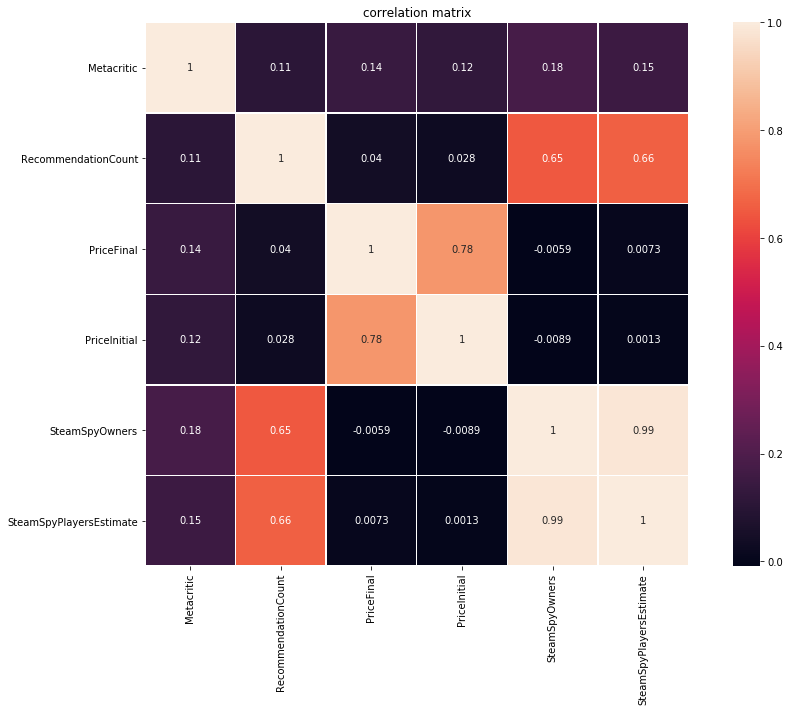

In [12]:
corrmat = data1[['Metacritic'] + contvar].corr()
sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title('correlation matrix')
plt.show()

From the previous selection we see that for Metacritic 
    - 1) we lost 10,684 observations 
    - 2) the mean increased by almost 60 
    - 3) I believe the reduction in variance is significant. Variance takes a lot of thinking.
    
We also several changes in the explanatory variables as well. One thing that we should notice is the high correlation between SteamSpyOwners and Steam player estimates.

# Let us now look at the relationship between Metacritic score and the categorical varables

We will start by getting a visual examination of the relationship between Metacritic score and Gategory as well as Genre.

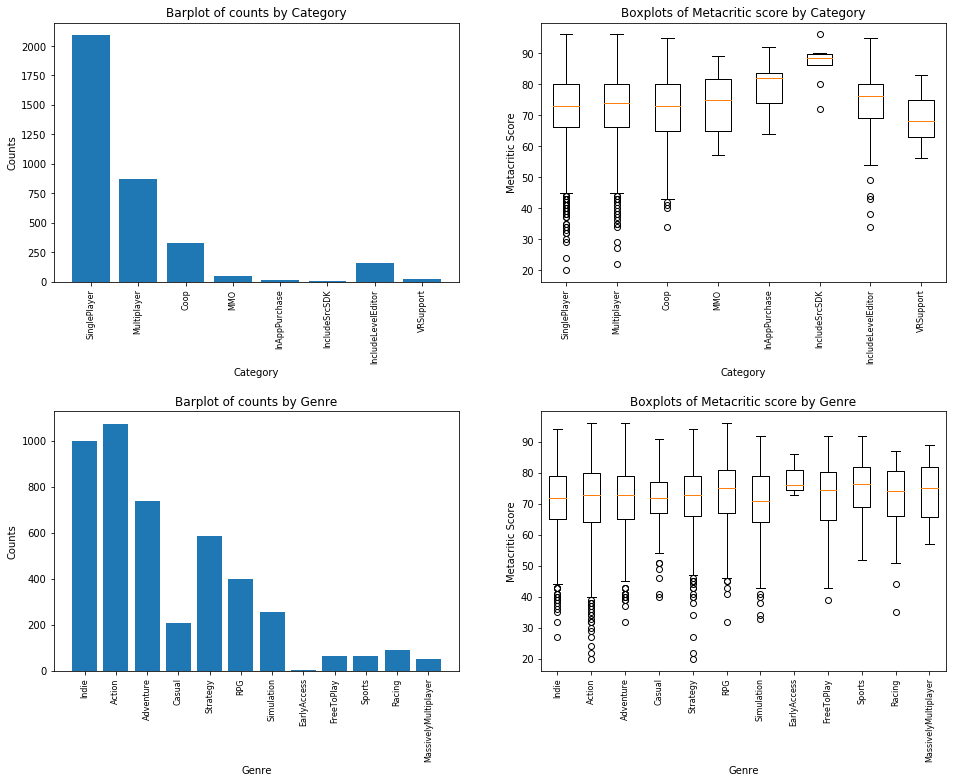

In [13]:
GameGenBox = {}    #empty dictionary
for item in list(gamegen):
    GameGenBox[item]=data1['Metacritic'][data1[item] == True]
lib={}

GameCatBox = {}    #empty dictionary
for item in list(gamecat):
    GameCatBox[item]=data1['Metacritic'][data1[item] == True]
lib={}

plt.rcParams['figure.figsize'] = (16,10)       #change the display size
fig, axs = plt.subplots(2, 2)
plt.subplots_adjust(bottom=.05, top=.95, hspace=.5)

axs[0 , 0].bar(gamecat, data1[gamecat].sum())
axs[0 , 0].set_title('Barplot of counts by Category')
axs[0 , 0].set_xticklabels([s[8:] for s in gamecat], rotation=90, fontsize=8)
axs[0 , 0].set_xlabel('Category')
axs[0 , 0].set_ylabel('Counts')

axs[0 , 1].boxplot(GameCatBox.values())
axs[0 , 1].set_title('Boxplots of Metacritic score by Category')
axs[0 , 1].set_xticklabels([s[8:] for s in gamecat], rotation=90, fontsize=8)
axs[0 , 1].set_xlabel('Category')
axs[0 , 1].set_ylabel('Metacritic Score')

axs[1 , 0].bar(gamegen, data1[gamegen].sum())
axs[1 , 0].set_title('Barplot of counts by Genre')
axs[1 , 0].set_xticklabels([s[7:] for s in gamegen], rotation=90, fontsize=8)
axs[1 , 0].set_xlabel('Genre')
axs[1 , 0].set_ylabel('Counts')


axs[1 , 1].boxplot(GameGenBox.values())
axs[1 , 1].set_title('Boxplots of Metacritic score by Genre')
axs[1 , 1].set_xticklabels([s[7:] for s in gamegen], rotation=90, fontsize=8)
axs[1 , 1].set_xlabel('Genre')
axs[1 , 1].set_ylabel('Metacritic Score')

plt.show()

# What do we see? <br>
We can see that the number of observations for each category and each genre greatly differ, but for the most part within Genre and Category the mean Metacritic score does not change, with only a few exceptions.


# But let us model this with regression


In [14]:
ols = sm.OLS(data1['Metacritic'],data1[['Intercept'] + contvar + gamecat + gamegen])
ols_result = ols.fit()
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Metacritic   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     10.93
Date:                Thu, 30 May 2019   Prob (F-statistic):           1.07e-40
Time:                        04:42:28   Log-Likelihood:                -8269.2
No. Observations:                2192   AIC:                         1.659e+04
Df Residuals:                    2166   BIC:                         1.674e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      65.8925      1.472     44.757      0.000      63.005      68.780
RecommendationCount          5.551e-06   8.75e-06      0.634      0.526   -1.16e-05    2.27e-05
PriceFinal                      0.1304      0.036      3.579      0.000       0.059       0.202
PriceInitial                    0.0266      0.028      0.965      0.334      -0.027       0.081
SteamSpyOwners               5.644e-06   6.32e-07      8.926      0.000     4.4e-06    6.88e-06
SteamSpyPlayersEstimate     -5.064e-06   6.62e-07     -7.651      0.000   -6.36e-06   -3.77e-06
CategorySinglePlayer            4.2669      1.324      3.223      0.001       1.670       6.863
CategoryMultiplayer             0.9725      0.577      1.686      0.092      -0.159       2.104
CategoryCoop                   -1.6289      0.720     -2.262      0.024      -3.041      -0.217
CategoryMMO                     0.3528      6.174      0.057      0.954     -11.755      12.461
CategoryInAppPurchase          -0.0027      3.148     -0.001      0.999      -6.176       6.171
CategoryIncludeSrcSDK          -0.9859      3.762     -0.262      0.793      -8.363       6.391
CategoryIncludeLevelEditor      2.4564      0.900      2.731      0.006       0.692       4.220
CategoryVRSupport              -2.2468      2.354     -0.954      0.340      -6.863       2.369
GenreIsIndie                   -0.6096      0.490     -1.244      0.214      -1.571       0.351
GenreIsAction                  -2.3634      0.520     -4.547      0.000      -3.383      -1.344
GenreIsAdventure               -0.7772      0.546     -1.424      0.155      -1.848       0.293
GenreIsCasual                   0.7721      0.801      0.964      0.335      -0.799       2.343
GenreIsStrategy                -0.7916      0.607     -1.303      0.193      -1.983       0.399
GenreIsRPG                      1.5944      0.617      2.585      0.010       0.385       2.804
GenreIsSimulation              -2.7420      0.753     -3.641      0.000      -4.219      -1.265
GenreIsEarlyAccess              9.0912      6.289      1.446      0.148      -3.242      21.425
GenreIsFreeToPlay              -4.5606      1.921     -2.374      0.018      -8.329      -0.793
GenreIsSports                   2.2524      1.533      1.469      0.142      -0.754       5.259
GenreIsRacing                  -0.8671      1.278     -0.678      0.498      -3.373       1.639
GenreIsMassivelyMultiplayer     5.1988      6.273      0.829      0.407      -7.103      17.500
==============================================================================
Omnibus:                      240.507   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.661
Skew:                          -0.824   Prob(JB):             

Using a cutoff of a P-value less than 5%, we can see that for:

Continuous variables
    - Unneeded variables: Recomendation Count, and Initial Price
    - Needed variables: PriceFinal, SteamSpyOwners, and SteamSpyPlayersEstimate
Game Category
    - Unneeded variables: Multiplayer, MMO, In App Purchases,SrcSDK, VRSupport
    - Needed variables: SinglePlayer, Coop, IncludeLevelEditor	
Game Genre
    - Unneeded variables: Indie, Adventure, Casual, Strategy, EarlyAccess  Sports, Racing, MassivelyMultiplayer
    - Needed variables: Action, RPG, Simulation,  FreeToPlay  
    
A simple way to test if we can drop these variables is with Anova. Let us do that right now.



In [15]:
contvar1=['PriceFinal','SteamSpyOwners',\
          'SteamSpyPlayersEstimate']

gamegen1= ['GenreIsAction','GenreIsRPG',\
           'GenreIsSimulation', 'GenreIsFreeToPlay']

gamecat1=['CategorySinglePlayer', 'CategoryCoop',\
          'CategoryIncludeLevelEditor']

ols1 = sm.OLS(data1['Metacritic'],data1[['Intercept']+ contvar1 + gamecat1 +gamegen1])
ols_result1 = ols1.fit()
anovaResults = anova_lm(ols_result1, ols_result)
print(anovaResults)
print(ols_result1.summary())

   df_resid            ssr  df_diff     ss_diff         F    Pr(>F)
0    2181.0  245431.011679      0.0         NaN       NaN       NaN
1    2166.0  242700.376689     15.0  2730.63499  1.624652  0.060071
                            OLS Regression Results                            
Dep. Variable:             Metacritic   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     24.77
Date:                Thu, 30 May 2019   Prob (F-statistic):           7.41e-45
Time:                        04:42:28   Log-Likelihood:                -8281.5
No. Observations:                2192   AIC:                         1.658e+04
Df Residuals:                    2181   BIC:                         1.665e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
      

C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The Anova test shows that these two models are statistically identical using an alpha cutoff of 0.05. We therefore choose to drop these variables. We also notice that CategoryCoop and GenreIsFreeToPlay are also now insignificant. For now though, let us continue using this model and assess some assumptions visually.

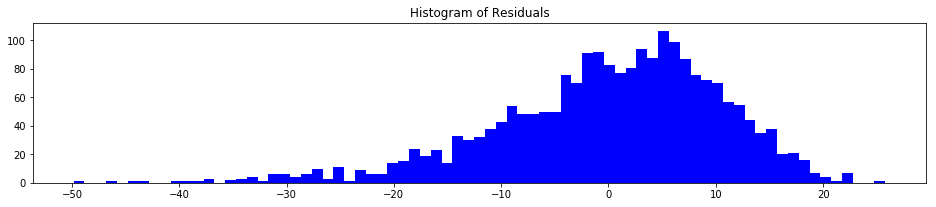

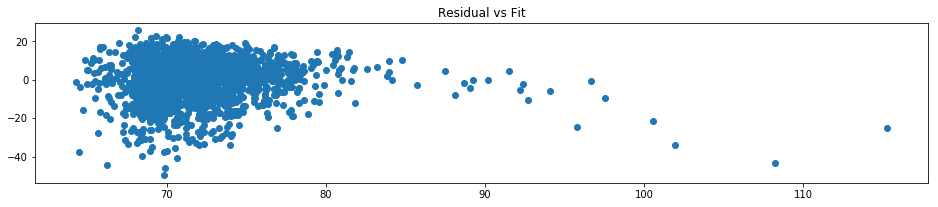

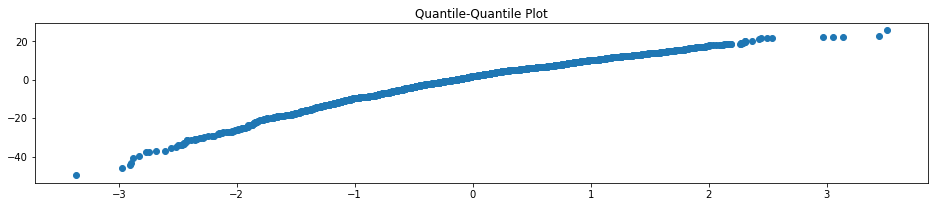

In [16]:
pred_val = ols_result1.fittedvalues.copy()
true_val = data1['Metacritic'].values.copy()
residual = true_val - pred_val
sortresidual = np.asarray(true_val - pred_val)
sortresidual.sort()
randnorm=np.random.normal(0, 1, data1.shape[0])
randnorm.sort()

plt.subplot(3, 1, 1)
plt.hist(residual, color='blue', bins=75)
plt.title('Histogram of Residuals')
plt.show()

plt.rcParams['figure.figsize'] = (16,10) 
plt.subplot(3, 1, 2)
plt.scatter(pred_val, residual )
plt.title('Residual vs Fit') 
plt.show()

plt.subplot(3, 1, 3)
plt.scatter(randnorm, sortresidual )
plt.title('Quantile-Quantile Plot')
plt.show()

We can see that for the most part this model appears to be normally distributed, though there is a slight left skew, and the variance seems to be somewhat equal, though this should be further investigated using statistical methods. 


# Conclusion
It appears on average, games with a non-zero metacritic score get an average score of 67. Metacritic scores increase when a game has a single player and includes a level editor and is an RPG. Metactitic scores also appear to be increasing as the number of owners increases, but decreases as the number of players increases. This is a strange thing to see, and should therefore be further investigated.

From this we can further research by:
- performing different techniques of analysis and comparing those results to what we have hear
- checking if the assumptions of regression are not violates
- using a generalized linear model
- possible variable transformations
- looking for interactions between the variables
- exploring variable "release date"
- more formal type of model selection. 


# General Data Science Conclusion
The most important piece of information I learned though came when trying to find inspiration for this project. I found out that Data Science:   

1) Does not require formal education <br>
2) Curiosity Powers Data Science <br>
3) Practice always yields improvement <br>
4) Experimentation is required <br> 
5) Writing/ Communication is important <br>

Writing this project with this in mind truly made the process easier as well as provides excouragement to continue the journey.

*https://towardsdatascience.com/what-i-learned-from-writing-a-data-science-article-every-week-for-a-year-201c0357e0ce
